# Introduction

I'm intending this to be the first notebook of two working with this data. This notebook will be focused on exploratory analysis and visualization and the second will be about making predictive models.

## Loading Data, Dealing with Missing Data, and Managing Column Names

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv("indian_liver_patient.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [3]:
data.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

There's 4 missing values in the Albumin and Globulin Ratio. It could be a useful predictor so it might be worthwhile to try estimating its value based on the mean of the most similar entries in the dataframe. Worst case, the data can be dropped as it's a small enough number it shouldn't affect the dataset one way or another.

In [4]:
missing = data[data.Albumin_and_Globulin_Ratio.isna()]

for index, row in missing.iterrows():
    age, disease, gender = row["Age"], row["Dataset"], row["Gender"]
    new_table = data[(data["Age"] == age) & (data["Gender"] == gender) & (data["Dataset"] == disease)]
    print(age, disease, gender, new_table["Albumin_and_Globulin_Ratio"].mean())
    data.set_value(index, "Albumin_and_Globulin_Ratio", new_table["Albumin_and_Globulin_Ratio"].mean())

45 1 Female 0.9
51 1 Male 0.89375
35 2 Female 1.8
27 2 Male 1.1025


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    583 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


I'm happy with the imputing for the missing values. The people with liver disease have slightly reduced ratios which would fit some possible impairment of Albumin synthesis by the liver while the people without liver disease have AGRs above 1

In [6]:
data = data.rename(columns = {"Alkaline_Phosphotase": "ALP", "Alamine_Aminotransferase": "ALT", "Aspartate_Aminotransferase": "AST", "Total_Protiens":"Protein", "Albumin_and_Globulin_Ratio": "AGR", "Dataset": "Liver Patient"})

data["Liver Patient"].replace(2, 0, inplace = True)

Renaming extremely long column names to their common abbreviations; changing Dataset variable to Liver Patient so it's not confusing as well as all 2s to 0s.

Previously a 1 meant liver patient and a 2 meant a non-liver patient; currently 0 means a non-liver patient and 1 means a liver patient.

Also for reference, ALP, AST, and ALT together may be called Liver Function Tests or LFTs for short. This is common medical shorthand, and will be used in this notebook.

# Exploratory Data Analysis

## Count Plots

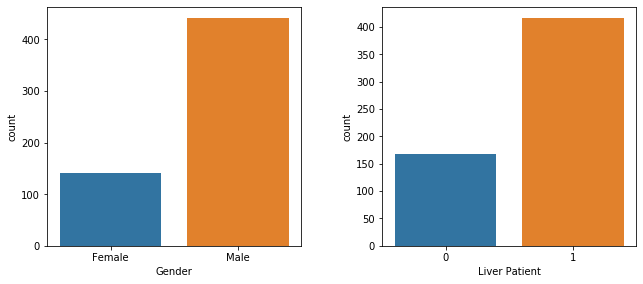

In [7]:
f, axes = plt.subplots(1, 2, figsize = (10, 5))
f.tight_layout(pad = 5)
sns.countplot(data = data, x = "Gender", ax = axes[0])
sns.countplot(data = data, x = "Liver Patient", ax = axes[1])

It's worth noting that this dataset is unbalanced in both Gender and Liver Patient status; there are considerably more men and liver patients than women and non-liver patients. It's not necessarily a problem in this case but extra caution will be required when building predictive models.

## Pivot Tables

In [8]:
pd.pivot_table(data, index = "Liver Patient")

,AGR,ALP,ALT,AST,Age,Albumin,Direct_Bilirubin,Protein,Total_Bilirubin
Liver Patient,,,,,,,,,
0,1.034626,219.754491,33.652695,40.688623,41.239521,3.344311,0.396407,6.543114,1.142515
1,0.914096,319.007212,99.605769,137.699519,46.153846,3.060577,1.923558,6.459135,4.164423


The pivot table shows mostly what's to be expected when you compare a population of liver patients with non-liver patients. Higher bilirubin levels; higher LFTs (ALT, ALP, AST); and lower Albumin and AGR levels in liver patients which is consistent with liver damage.

In [9]:
pd.pivot_table(data[[col for col in data.columns if col != "Liver Patient"]], index = "Gender")

,AGR,ALP,ALT,AST,Age,Albumin,Direct_Bilirubin,Protein,Total_Bilirubin
Gender,,,,,,,,,
Female,0.954648,302.338028,54.239437,69.042254,43.133803,3.273239,0.989437,6.653521,2.322535
Male,0.946681,286.789116,89.238095,123.070295,45.265306,3.099546,1.646032,6.428345,3.613152


Men tend to have higher values for ALT, and AST. They also seem to have slightly lower Albumin and Protein levels as well. Bilirubin levels are much higher in men.

In [10]:
pd.pivot_table(data, index = ["Liver Patient", "Gender"])

AGR         ALP         ALT         AST        Age  \
Liver Patient Gender                                                            
0             Female  1.023200  203.280000   29.740000   31.840000  42.740000   
              Male    1.039509  226.794872   35.324786   44.470085  40.598291   
1             Female  0.917391  356.173913   67.554348   89.260870  43.347826   
              Male    0.913160  308.453704  108.706790  151.453704  46.950617   

                       Albumin  Direct_Bilirubin   Protein  Total_Bilirubin  
Liver Patient Gender                                                         
0             Female  3.350000          0.268000  6.580000         0.906000  
              Male    3.341880          0.451282  6.527350         1.243590  
1             Female  3.231522          1.381522  6.693478         3.092391  
              Male    3.012037          2.077469  6.392593         4.468827

When combining Gender and Liver Patient status into a pivot table, a few things change. The higher ALP levels in women from the previous pivot table appears to come from the women who happen to be liver patients. Of those that aren't liver patients, men have higher ALP levels. In similar fashion, the higher Albumin and Protein numbers in women appears to be explained by the liver patients. Men still have higher ALT, AST, and Bilirubin but these differences are more pronounced in liver patients. 

## Dealing with Outliers

In [11]:
data.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,ALP,ALT,AST,Protein,Albumin,AGR,Liver Patient
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.948621,0.713551
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.320523,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


Many of the liver metrics have gigantic jumps from the 75th percentile value to the max value, and this is to be expected as you'll occasionally have patients with extremely high lab values. In this case, these values are likely to severely compress graphs when running data through matplotlib and seaborn, so I'll be working on removing the high values. There's no reason to worry about abnormally low values because 0 is the lowest anything can be.

In [12]:
outliers = data[["Total_Bilirubin", "Direct_Bilirubin", "ALP", "ALT", "AST", "Protein", "Albumin", "AGR"]].copy()
index = outliers[(np.abs(stats.zscore(outliers)) < 2.5).all(axis = 1)].index
index2 = outliers[(np.abs(stats.zscore(outliers)) < 2).all(axis = 1)].index

outliers_25z = data.iloc[index, ].copy()
outliers_2z = data.iloc[index2, ].copy()

I've made two sets filtering outliers; one set is within a z-score of 2.5 and the other is within a z-score of 2.

In [13]:
outliers_25z.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,ALP,ALT,AST,Protein,Albumin,AGR,Liver Patient
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,44.708087,2.022288,0.885404,254.143984,52.287968,69.084813,6.520710,3.185602,0.948139,0.686391
std,16.381736,2.719872,1.447358,138.690520,56.852662,90.321794,0.996845,0.756820,0.275817,0.464418
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,3.800000,1.400000,0.300000,0.000000
25%,33.000000,0.800000,0.200000,173.000000,22.000000,24.000000,5.900000,2.600000,0.800000,0.000000
50%,45.000000,0.900000,0.300000,202.000000,32.000000,39.000000,6.600000,3.100000,1.000000,1.000000
75%,58.000000,2.000000,0.900000,285.500000,55.000000,71.500000,7.200000,3.800000,1.100000,1.000000
max,90.000000,18.400000,8.500000,862.000000,407.000000,794.000000,8.900000,5.000000,1.720000,1.000000


In [14]:
outliers_2z.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,ALP,ALT,AST,Protein,Albumin,AGR,Liver Patient
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,44.634989,1.728294,0.734341,248.168467,50.339093,64.034557,6.562203,3.209935,0.944609,0.678186
std,16.378327,1.921297,1.050854,123.146666,53.834639,80.098011,0.929447,0.696706,0.249305,0.467677
min,4.000000,0.500000,0.100000,63.000000,10.000000,10.000000,4.400000,1.600000,0.370000,0.000000
25%,33.000000,0.800000,0.200000,173.000000,22.000000,24.000000,5.900000,2.700000,0.800000,0.000000
50%,45.000000,0.900000,0.300000,202.000000,32.000000,38.000000,6.600000,3.200000,1.000000,1.000000
75%,57.000000,1.800000,0.800000,282.000000,53.000000,67.500000,7.200000,3.800000,1.100000,1.000000
max,90.000000,14.500000,7.000000,750.000000,407.000000,630.000000,8.600000,4.700000,1.580000,1.000000


Using a z-score of 2.5 trimmed off 76 observations that had extreme values in any of the following: Bilirubin, LFTs, Protein, and/or AGR levels. Using a z-score of 2 further trimmed off 44 observations for a grand total of 120 removals. The z-score of 2 brought down the maximum values slightly except for ALT. Whether this has an impact on distribution remains to be seen.

## Visualization

The data without outliers is only necessary for the distribution plots as seaborn's boxplots can be given the showfliers argument to remove outliers from plots.

### LFT Distribution by Gender and Chronic Liver Disease Status - Outliers > 2.5 z-score removed

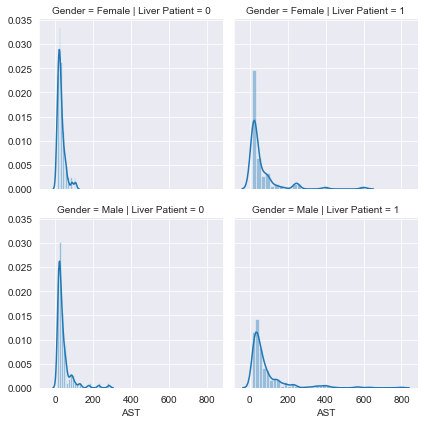

In [15]:
sns.set_style("darkgrid")
graph = sns.FacetGrid(outliers_25z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "AST")
graph

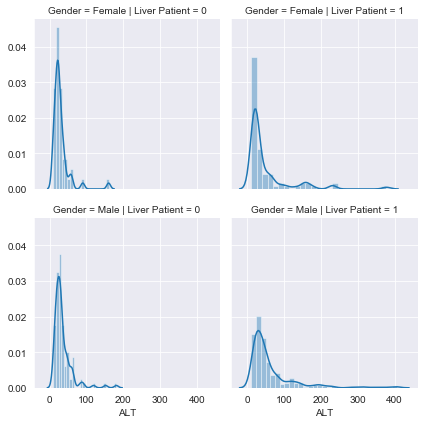

In [16]:
graph = sns.FacetGrid(outliers_25z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "ALT")
graph

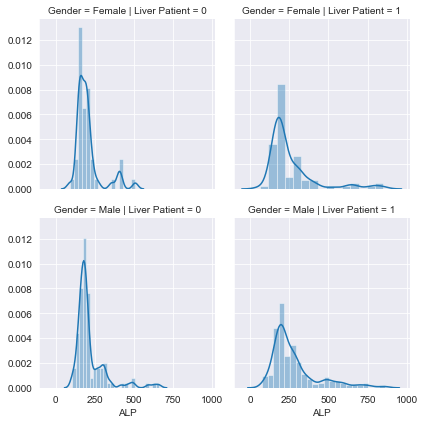

In [17]:
graph = sns.FacetGrid(outliers_25z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "ALP")
graph

### LFT Distribution by Gender and Chronic Liver Disease Status - Outliers > 2 z-score removed

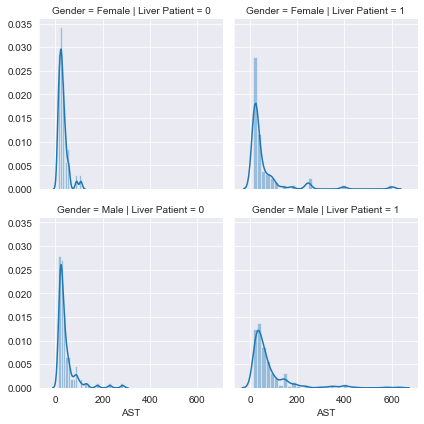

In [18]:
sns.set_style("darkgrid")
graph = sns.FacetGrid(outliers_2z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "AST")
graph

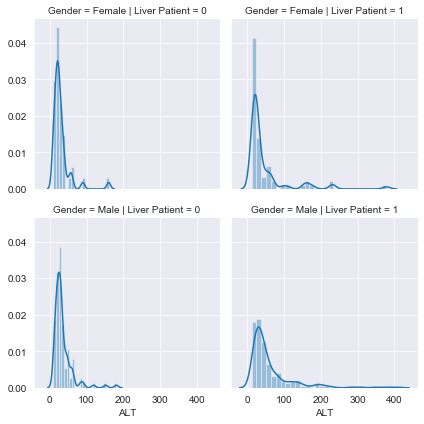

In [19]:
sns.set_style("darkgrid")
graph = sns.FacetGrid(outliers_2z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "ALT")
graph

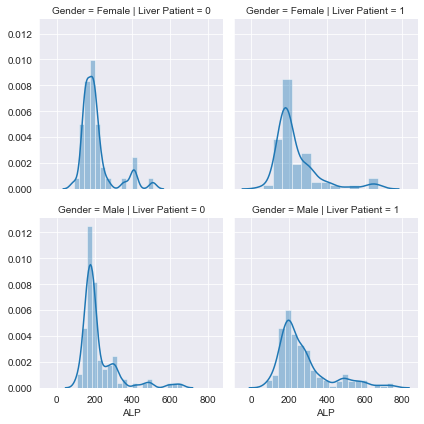

In [20]:
sns.set_style("darkgrid")
graph = sns.FacetGrid(outliers_2z, col = "Liver Patient", row = "Gender")
graph.map(sns.distplot, "ALP")
graph

Both outlier trimmed datasets have roughly similar distributions for LFTs with the 2 z-score set having slightly less compressed graphs due to the lower max values. 

The liver patients tend to have more right skewed data than the non-liver patients which fits the data description as well as medical expectations. Liver patients are more likely to have extreme values in LFTs than non-liver patients. ALP was a bit of an exception as there was a fair deal of right skewing in non-liver patients. This is fairly reasonable as liver damage is not the only source of high ALP in the body; bone disorders can also cause elevations in ALP levels. Since the non-liver patients are still patients, it follows that they could have another ALP elevating condition. 

### Boxplots with Entire Dataset

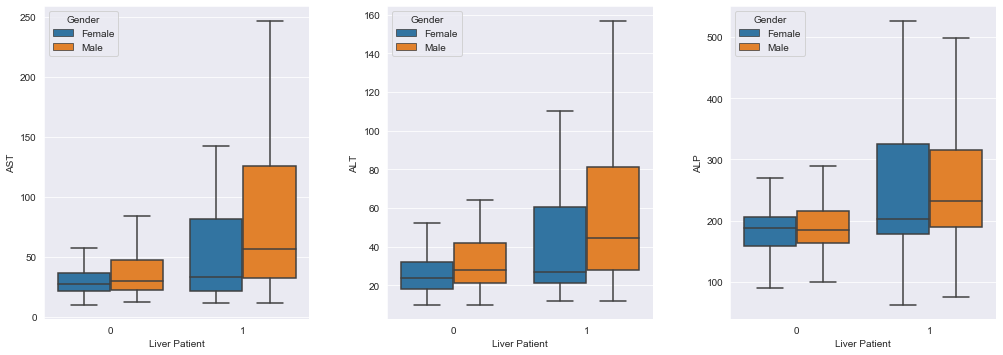

In [21]:
f, axes = plt.subplots(1, 3, figsize = (15, 6))
f.tight_layout(pad = 5)
sns.boxplot(x = "Liver Patient", y = "AST", hue = "Gender", data = data, orient = 'v', ax = axes[0], showfliers = False)
sns.boxplot(x = "Liver Patient", y = "ALT", hue = "Gender", data = data, orient = 'v', ax = axes[1], showfliers = False)
sns.boxplot(x = "Liver Patient", y = "ALP", hue = "Gender", data = data, orient = 'v', ax = axes[2], showfliers = False)

LFT boxplots shows much the same from the distplots from above. Although I think some of the increased variability in ALP levels is better communicated in the distplots above.

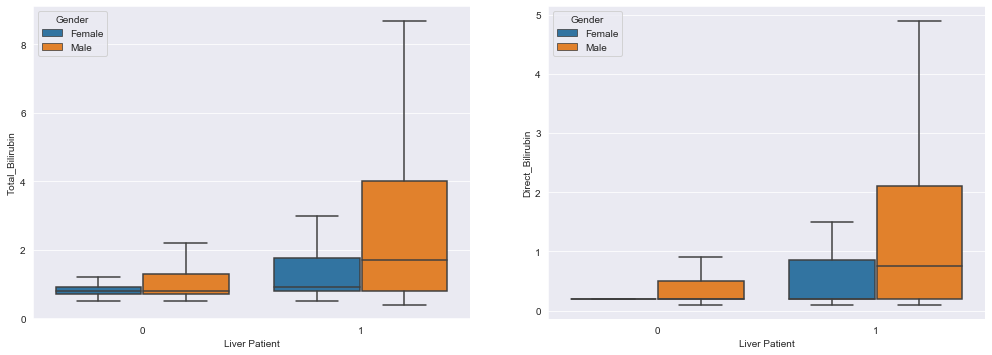

In [22]:
sns.set_style("darkgrid")
f, axes = plt.subplots(1, 2, figsize = (15, 6))
f.tight_layout(pad = 5)
sns.boxplot(x = "Liver Patient", y = "Total_Bilirubin", hue = "Gender", data = data, orient = 'v', ax = axes[0], showfliers = False)
sns.boxplot(x = "Liver Patient", y = "Direct_Bilirubin", hue = "Gender", data = data, orient = 'v', ax = axes[1], showfliers = False)

While the Bilirubin levels in non-liver patients appears very low, they're actually more or less normal. Total Bilirubin of 1.2 mg/dL or less is the roughly normal reference value and Direct Bilirubin is about 0.3 mg/dL or less. The very large boxplots for the liver patient groups is indicative of the excess Bilirubin that's present in liver damage and the large amount of variability. On a related note, the male non-liver patients actually have somewhat elevated Bilirubin as a group but again, a few other conditions (e.g. hemolytic anemia) can cause high Bilirubin without a primary hepatic cause. 

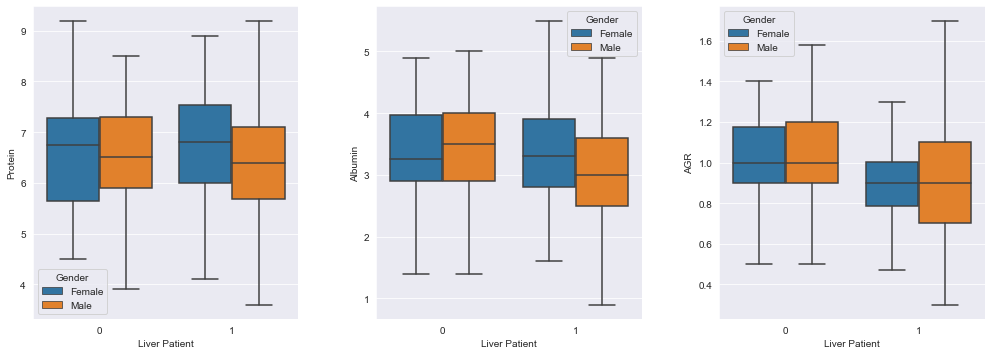

In [23]:
f, axes = plt.subplots(1, 3, figsize = (15, 6))
f.tight_layout(pad = 5)
sns.boxplot(x = "Liver Patient", y = "Protein", hue = "Gender", data = data, orient = 'v', ax = axes[0], showfliers = False)
sns.boxplot(x = "Liver Patient", y = "Albumin", hue = "Gender", data = data, orient = 'v', ax = axes[1], showfliers = False)
sns.boxplot(x = "Liver Patient", y = "AGR", hue = "Gender", data = data, orient = 'v', ax = axes[2], showfliers = False)

While there's some increased variability in the liver patients, both liver patients and non-patients have similar distributions of protein metrics (protein, albumin, AGR). The values suggest that approximately half of all patients fall below the minimum values for normal protein and albumin. Now in a liver setting, this can often be a sign of cirrhosis or severe, chronic liver disease. Basically, low protein and albumin in liver disease may suggest that the liver is so impaired that it cannot make vital proteins at a normal rate anymore. However, there are other reasons for low values including renal disease (e.g. Nephrotic Syndrome) and fluid retention (e.g. Congestive Heart Failure). These may be more applicable to the non-liver patients but can apply to the liver patients too. 

# Impressions

The data appears to show increased variability in Men and Liver Patients in laboratory test values with the exception of ALP and Proteins (Albumin, AGR, and Protein). As many of the included lab values strongly pertain to liver function, it's fair to see the increased variability, and higher mean values in the Liver Patient group. Epidemiological studies suggest that men are more likely to die from chronic liver disease, and so are more likely to have it over women. That could potentially explain the gender differences. 

To move forward with this data for predictive modeling, and test values would have to be scaled. Further, given that the dataset is unbalanced on both Gender and Liver Patient status, care will have to taken to ensure that the chosen model isn't impaired by that. Potential management of the unbalanced data could be via undersampling using the imbalanced-learn package.